In [1]:
import os, sys
sys.path.append("/content")
import pickle, argparse
from src.utils import MultipleRegression, predict_chip
import torch, pickle, torch.nn as nn

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [2]:
parser = argparse.ArgumentParser()
# parser.add_argument('--model_path',
#     type=str,
#     help="The path to the model state file (.pt file) without the subscript.")
parser.add_argument('--data_src',
    type=str,
    choices=["itv", "ana", "usgs", "usgsi"],
    help="name of data source")
parser.add_argument('--cloud_thr',
    default=80,
    type=int,
    help="percent of cloud cover acceptable")
parser.add_argument('--buffer_distance',
    default=500,
    type=int,
    help="search radius used for reflectance data aggregation")
parser.add_argument('--mask_method1',
    default="lulc",
    choices=["lulc", "scl"],
    type=str,
    help="Which data to use for masking non-water, scl only (\"scl\"), or io_lulc plus scl (\"lulc\")")
parser.add_argument('--mask_method2',
    default="mndwi",
    choices=["ndvi", "mndwi", ""],
    type=str,
    help="Which additional index, if any, to use to update the mask, (\"ndvi\") or (\"mndwi\")")
args = parser.parse_args(args=[])
args.model_path = "/content/output/mlp/top_model_tmp"
day_tolerance = 0

In [3]:
# Load in the top model metadata
with open(f"{args.model_path}_metadata.pickle", "rb") as f:
    meta = pickle.load(f)

model = MultipleRegression(len(meta["features"]), len(meta["layer_out_neurons"]), meta["layer_out_neurons"], activation_function=eval(f'nn.{meta["activation"]}'))
with open(f"{args.model_path}.pt", "rb") as f:
    model.load_state_dict(torch.load(f))
print(meta["training_data"])

/content/local/partitioned_feature_data_buffer500m_daytol8_cloudthr80percent_lulcmndwi_masking_5folds.csv


In [4]:
###### Make pixel-level predictions
import pandas as pd, numpy as np, rasterio as rio
fp = meta["training_data"]
data = pd.read_csv(fp)

features = meta["features"]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(data[meta["features"]])

not_enough_water = data["n_water_pixels"] <= meta["min_water_pixels"]
data.drop(not_enough_water[not_enough_water].index, inplace=True)
data["Log SSC (mg/L)"] = np.log(data["SSC (mg/L)"])
data["is_brazil"] = [float(x) for x in data["is_brazil"]]
lnssc_0 = data["Log SSC (mg/L)"] == 0
data.drop(lnssc_0[lnssc_0].index, inplace=True)

sentinel_features = [x for x in features if "sentinel" in x]
non_sentinel_features = [x for x in features if "sentinel" not in x]
observation = data.reset_index().loc[list(data["sample_id"]).index("0000ITV6_00000017"), :]


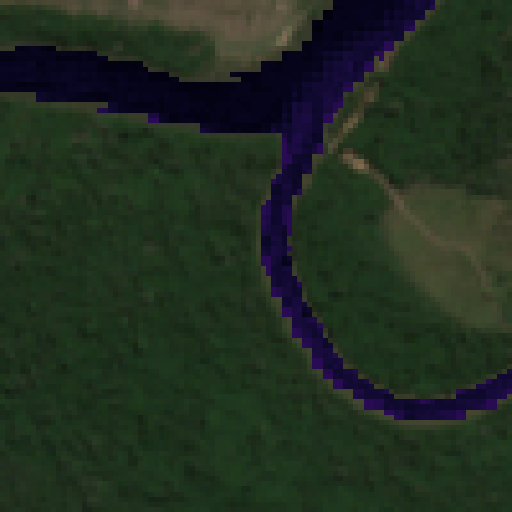

In [6]:
pred_chip = predict_chip(features, sentinel_features, non_sentinel_features, observation, model, scaler)
from PIL import Image
Image.fromarray(pred_chip).resize((512, 512), Image.NEAREST).show()